# Klimadaten

Ist Grächen ein sicherer Wintersportort?

Wir verwenden Pandas um die Daten zu verarbeiten.

In [ ]:
%pip install pandas matplotlib statsmodels

Die Datenbank laden:

In [119]:
import pandas as pd

# 1) Load CSV data and parse 'time' column as date with YYYYMMDD format.
df = pd.read_csv('data/order_117249_data.txt', sep=';', parse_dates=['time'], date_format='%Y%m%d')

# Look at the data
df

,stn,time,tre200dx,tre200dn,hto000d0,tre200d0,rre150d0,hns000d0
0,GRC,1864-01-01,-,-,-,-5.5,0.0,-
1,GRC,1864-01-02,-,-,-,-11.6,0.7,-
2,GRC,1864-01-03,-,-,-,-16.6,0.0,-
3,GRC,1864-01-04,-,-,-,-6.2,0.0,-
4,GRC,1864-01-05,-,-,-,-6.9,0.0,-
...,...,...,...,...,...,...,...,...
58418,GRC,2023-12-11,4.5,-0.6,30,2.4,22.5,0
58419,GRC,2023-12-12,4.1,0.5,23,2.7,15.5,1
58420,GRC,2023-12-13,0.9,-1.9,19,-0.4,1.8,1
58421,GRC,2023-12-14,1.1,-3.3,20,-1.7,0.0,0


### Massage data to be in proper shape.

 * Rename 'hto000d0' column to 'snowheight'.
 * Only retain the interesting columns.
 * Drop rows with missing values for snowheight (-).
 * Convert snowheight column to numeric data instead of strings.
 * Extract a year column
   * Since we converted the 'time' column to be proper dates, we can simply use the datetime built-in.


In [120]:
df = df.rename(columns={'hto000d0':'snowheight'})
df = df[['time', 'snowheight']]
df = df.loc[df['snowheight'] != '-']
df.snowheight = pd.to_numeric(df.snowheight)

df['year'] = df['time'].dt.year

# Look at the data
df

,time,snowheight,year
37255,1966-01-01,80,1966
37256,1966-01-02,78,1966
37257,1966-01-03,83,1966
37258,1966-01-04,93,1966
37259,1966-01-05,88,1966
...,...,...,...
58418,2023-12-11,30,2023
58419,2023-12-12,23,2023
58420,2023-12-13,19,2023
58421,2023-12-14,20,2023


Compute a fresh dataset for the start of the snow-season:
* Group the daily values by year, then select the largest date (last day) for which there was zero snow.
* Note: Instead of zero, we could look for snowheight < some_limit.
* Drop the snowheight column.
* Rename the time column to describe what it contains.

We do the same for the end of the season, but look for the maximum date.
Also, we need to decrement the year, to properly match it up with the season that started the previous year.

In [126]:

beginseason = df.loc[df['snowheight'] == 0].groupby(['year']).max()
beginseason = beginseason.drop('snowheight', axis=1)
beginseason = beginseason.rename(columns={'time': 'snowstart'})

# The same for the end of the season.
endseason = df.loc[df['snowheight'] == 0].groupby(['year']).min()
endseason = endseason.drop('snowheight', axis=1)
endseason = endseason.rename(columns={'time': 'snowend'})
# We use the year of the season-start to identify a season - so we need to
# decrement the year for season end to match it up with the season start.
endseason.index -= 1

# Look at the data
endseason.tail(n=10)

,snowend
year,
2013,2014-03-21
2014,2015-03-19
2015,2016-01-01
2016,2017-01-01
2017,2018-04-14
2018,2019-02-28
2019,2020-02-24
2020,2021-03-01
2021,2022-03-01


#### Join begin and end
The 'year' column is the index of the grouped datasets, so join automatically selects it as join key.

Also compute the length of the season in days: the difference between end and start, -1 as we measure from the first day with zero snow.

In [128]:
seasons = beginseason.join(endseason, how='inner')
seasons['season_duration_days'] = (seasons['snowend'] - seasons['snowstart']).dt.days - 1
seasons.tail(n=10)

,snowstart,snowend,season_duration_days
year,,,
2013,2013-11-20,2014-03-21,120
2014,2014-12-26,2015-03-19,82
2015,2015-12-31,2016-01-01,0
2016,2016-12-31,2017-01-01,0
2017,2017-12-07,2018-04-14,127
2018,2018-12-07,2019-02-28,82
2019,2019-11-29,2020-02-24,86
2020,2020-12-01,2021-03-01,89
2021,2021-11-30,2022-03-01,90


#### Plotting

Plot the season length:

<Axes: xlabel='year'>

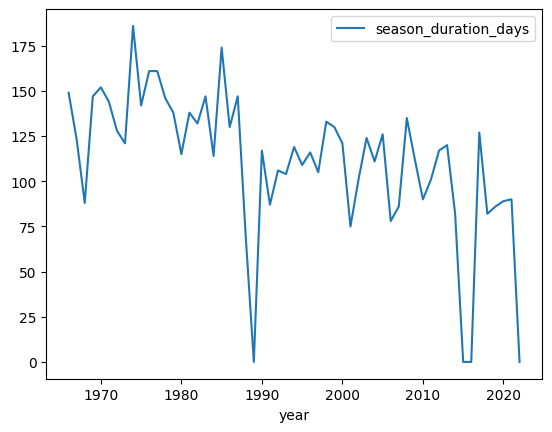

In [129]:
from matplotlib import pyplot
seasons.plot(y='season_duration_days')

#### Trend line
Compute a linear regression and add it to the graph.

Looks like statsmodels cannot regress on the index column, so re-add the year as a separate column 'x'.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             GLS Regression Results                             
================================================================================
Dep. Variable:     season_duration_days   R-squared:                       0.319
Model:                              GLS   Adj. R-squared:                  0.307
Method:                   Least Squares   F-statistic:                     25.81
Date:                  Wed, 24 Jan 2024   Prob (F-statistic):           4.65e-06
Time:                          09:07:09   Log-Likelihood:                -279.57
No. Observations:                    57   AIC:                             563.1
Df Residuals:                        55   BIC:                             567.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2821.6074    533.576      5.288      0.000    1752.296    3890.918
x             -1.3593      0.268     -5.080      0.000      -1.896      -0.823
==============================================================================
Omnibus:                       23.034   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.831
Skew:                          -1.439   Prob(JB):                     2.73e-08
Kurtosis:                       5.526   Cond. No.                     2.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

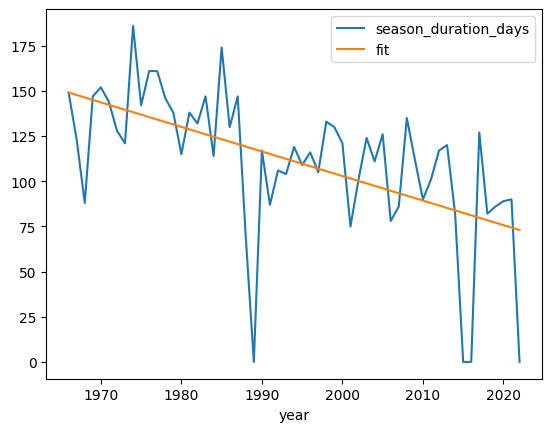

In [130]:
import statsmodels.api as sm

seasons['x'] = seasons.index
model = sm.formula.gls(formula='season_duration_days ~ x', data=seasons)
res = model.fit()
seasons = seasons.assign(fit=res.fittedvalues)

fig, ax = pyplot.subplots()
seasons.plot(y='season_duration_days', ax=ax)
seasons.plot(y='fit', ax=ax)

res.summary()
